In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json
/content


In [ ]:
!unzip drive/My\ Drive/Data/dog-breed-identification.zip

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import os.path
from PIL import Image
import time
import copy
from tqdm import tqdm, notebook
from pathlib import Path
from sklearn.model_selection import train_test_split

In [2]:
train_dir = "./drive/My Drive/Data/train"
test_dir = "./drive/My Drive/Data/test"
label_path = "./drive/My Drive/Data/labels.csv"
sample_path = "./drive/My Drive/Data/sample_submission.csv"

In [ ]:
print(os.path.isdir(train_dir))
print(os.path.isdir(test_dir))

True
True


In [3]:
def black_background_thumbnail(image, thumbnail_size=(224,224)):
    background = Image.new('RGB', thumbnail_size, "black")    
    source_image = image.convert("RGB")
    source_image.thumbnail(thumbnail_size)
    (w, h) = source_image.size
    background.paste(source_image, (int((thumbnail_size[0] - w) / 2), int((thumbnail_size[1] - h) / 2) ))
    return background

class CDataset(Dataset):
    def __init__(self, ds, img_dir, class_df, class_to_idx, transform=None,): 
        self.ds = ds
        self.img_dir = img_dir
        self.class_df = class_df
        self.class_to_idx = class_to_idx
        self.transform = transform if transform else None
        
    def __len__(self): 
        return len(self.ds)
    
    def read_image(self, loc):
        img_arr = Image.open(loc.as_posix())
        return img_arr.convert('RGB')
        
    def __getitem__(self, i):
        img = self.read_image(self.ds[i])
        img = black_background_thumbnail(img)
        if self.transform:
            img = self.transform(img)
        label = self.ds[i].name.split('.')[0]
        kls = self.class_df[self.class_df['id'] == label]
        return img, self.class_to_idx[kls.iloc[0].breed]

In [10]:
PATH = Path('./drive/My Drive/Data/')
class_df = pd.read_csv(PATH/'labels.csv')
class_df.head()
class_to_idx = {x:i for i,x in enumerate(class_df.breed.unique())}
idx_to_class = {i:x for i,x in enumerate(class_df.breed.unique())}
img_dir = PATH/'train'
sample = list(img_dir.iterdir())
train, test = train_test_split(sample)
batch_size=58

transform = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


train_ds = CDataset(train, img_dir, class_df, class_to_idx, transform=transform)
test_ds = CDataset(test, img_dir, class_df, class_to_idx, transform=transform)
train_dl = DataLoader(train_ds, batch_size=batch_size)
test_dl = DataLoader(test_ds, batch_size=batch_size)
dataloaders = {'train': train_dl, 'val':test_dl}

In [ ]:
print(len(train_ds))
print(len(test_ds))

7666
2556


In [ ]:
if torch.cuda.is_available():
    use_gpu = True
    print("Using GPU")
else:
    use_gpu = False
FloatTensor = torch.cuda.FloatTensor if use_gpu else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_gpu else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_gpu else torch.ByteTensor
Tensor = FloatTensor

model_ft = models.resnet152(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 120)

if use_gpu:
   model_ft.cuda()

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

Using GPU


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [ ]:
def train_model(model, criterion, optimizer, losses, accuracy, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        start = time.time()
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            data_loader = dataloaders[phase]
            for data in notebook.tqdm(data_loader):
                # get the inputs
                inputs, labels = data
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda(),)
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                # statistics
                running_loss += loss.item()  * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)
            losses.append(epoch_loss)
            accuracy.append(epoch_acc)
            epoch_time = time.time() - start
            tqdm.write('{} Loss: {:.4f} Acc: {:.4f} in {:.0f}m {:.0f}s'.format(
                phase, epoch_loss, epoch_acc, epoch_time // 60, epoch_time % 60))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        tqdm.write('')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
losses, accuracy = [], []
model = train_model(model_ft, criterion, optimizer_ft, losses, accuracy, num_epochs=25)

torch.save(model_ft, '/content/drive/My Drive/DogBreeding.pth')

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [1:17:12<?, ?it/s]


train Loss: 3.6734 Acc: 0.3540 in 77m 13s


  4%|▍         | 1/25 [1:42:51<41:08:42, 6171.77s/it]


val Loss: 2.4823 Acc: 0.6197 in 102m 52s



  4%|▍         | 1/25 [1:44:22<41:08:42, 6171.77s/it]


train Loss: 1.9099 Acc: 0.7172 in 1m 31s


  8%|▊         | 2/25 [1:44:52<27:49:58, 4356.46s/it]


val Loss: 1.4737 Acc: 0.7563 in 2m 1s



  8%|▊         | 2/25 [1:46:23<27:49:58, 4356.46s/it]


train Loss: 1.2605 Acc: 0.7965 in 1m 31s


 12%|█▏        | 3/25 [1:46:53<18:51:26, 3085.77s/it]


val Loss: 1.1161 Acc: 0.7860 in 2m 1s



 12%|█▏        | 3/25 [1:48:24<18:51:26, 3085.77s/it]


train Loss: 0.9879 Acc: 0.8225 in 1m 31s


 16%|█▌        | 4/25 [1:48:54<12:48:43, 2196.35s/it]


val Loss: 0.9437 Acc: 0.8001 in 2m 1s



 16%|█▌        | 4/25 [1:50:24<12:48:43, 2196.35s/it]


train Loss: 0.8423 Acc: 0.8382 in 1m 30s


 20%|██        | 5/25 [1:50:54<8:44:31, 1573.57s/it] 


val Loss: 0.8512 Acc: 0.8091 in 2m 0s



 20%|██        | 5/25 [1:52:25<8:44:31, 1573.57s/it]


train Loss: 0.7488 Acc: 0.8525 in 1m 30s


 24%|██▍       | 6/25 [1:52:55<6:00:14, 1137.61s/it]


val Loss: 0.7969 Acc: 0.8083 in 2m 0s



 24%|██▍       | 6/25 [1:54:25<6:00:14, 1137.61s/it]


train Loss: 0.6846 Acc: 0.8592 in 1m 30s


 28%|██▊       | 7/25 [1:54:55<4:09:42, 832.37s/it] 


val Loss: 0.7518 Acc: 0.8130 in 2m 0s



 28%|██▊       | 7/25 [1:56:25<4:09:42, 832.37s/it]


train Loss: 0.6363 Acc: 0.8688 in 1m 31s


 32%|███▏      | 8/25 [1:56:56<2:55:20, 618.87s/it]


val Loss: 0.7335 Acc: 0.8079 in 2m 1s



 32%|███▏      | 8/25 [1:58:26<2:55:20, 618.87s/it]


train Loss: 0.5947 Acc: 0.8741 in 1m 31s


 36%|███▌      | 9/25 [1:58:56<2:05:11, 469.45s/it]


val Loss: 0.7090 Acc: 0.8122 in 2m 1s



 36%|███▌      | 9/25 [2:00:27<2:05:11, 469.45s/it]


train Loss: 0.5618 Acc: 0.8771 in 1m 30s


 40%|████      | 10/25 [2:00:57<1:31:12, 364.83s/it]


val Loss: 0.6941 Acc: 0.8142 in 2m 1s



 40%|████      | 10/25 [2:02:27<1:31:12, 364.83s/it]


train Loss: 0.5354 Acc: 0.8846 in 1m 30s


 44%|████▍     | 11/25 [2:02:58<1:08:01, 291.53s/it]


val Loss: 0.6711 Acc: 0.8153 in 2m 0s



 44%|████▍     | 11/25 [2:04:27<1:08:01, 291.53s/it]


train Loss: 0.5085 Acc: 0.8889 in 1m 30s


 48%|████▊     | 12/25 [2:04:58<52:00, 240.07s/it]  


val Loss: 0.6641 Acc: 0.8173 in 1m 60s



 48%|████▊     | 12/25 [2:06:27<52:00, 240.07s/it]


train Loss: 0.4889 Acc: 0.8903 in 1m 30s


 52%|█████▏    | 13/25 [2:06:57<40:47, 203.94s/it]


val Loss: 0.6583 Acc: 0.8216 in 1m 59s



 52%|█████▏    | 13/25 [2:08:27<40:47, 203.94s/it]


train Loss: 0.4696 Acc: 0.8939 in 1m 30s


 56%|█████▌    | 14/25 [2:08:57<32:45, 178.72s/it]


val Loss: 0.6545 Acc: 0.8130 in 1m 60s



 56%|█████▌    | 14/25 [2:10:27<32:45, 178.72s/it]


train Loss: 0.4518 Acc: 0.8981 in 1m 30s


 60%|██████    | 15/25 [2:10:57<26:51, 161.17s/it]


val Loss: 0.6468 Acc: 0.8177 in 2m 0s



 60%|██████    | 15/25 [2:12:27<26:51, 161.17s/it]


train Loss: 0.4345 Acc: 0.9023 in 1m 30s


 64%|██████▍   | 16/25 [2:12:58<22:20, 148.90s/it]


val Loss: 0.6439 Acc: 0.8185 in 2m 0s



 64%|██████▍   | 16/25 [2:14:27<22:20, 148.90s/it]


train Loss: 0.4225 Acc: 0.9044 in 1m 30s


 68%|██████▊   | 17/25 [2:14:58<18:41, 140.23s/it]


val Loss: 0.6285 Acc: 0.8212 in 1m 60s



 68%|██████▊   | 17/25 [2:16:28<18:41, 140.23s/it]


train Loss: 0.4069 Acc: 0.9112 in 1m 30s


 72%|███████▏  | 18/25 [2:16:58<15:40, 134.35s/it]


val Loss: 0.6299 Acc: 0.8236 in 2m 1s



 72%|███████▏  | 18/25 [2:18:28<15:40, 134.35s/it]


train Loss: 0.3947 Acc: 0.9117 in 1m 30s


 76%|███████▌  | 19/25 [2:18:58<13:00, 130.04s/it]


val Loss: 0.6294 Acc: 0.8173 in 1m 60s



 76%|███████▌  | 19/25 [2:20:29<13:00, 130.04s/it]


train Loss: 0.3847 Acc: 0.9168 in 1m 30s


 80%|████████  | 20/25 [2:20:59<10:36, 127.26s/it]


val Loss: 0.6257 Acc: 0.8228 in 2m 1s



 80%|████████  | 20/25 [2:22:29<10:36, 127.26s/it]


train Loss: 0.3698 Acc: 0.9200 in 1m 30s


 84%|████████▍ | 21/25 [2:22:59<08:20, 125.16s/it]


val Loss: 0.6206 Acc: 0.8259 in 2m 0s



 84%|████████▍ | 21/25 [2:24:29<08:20, 125.16s/it]


train Loss: 0.3638 Acc: 0.9229 in 1m 30s


 88%|████████▊ | 22/25 [2:24:59<06:10, 123.61s/it]


val Loss: 0.6231 Acc: 0.8142 in 1m 60s



 88%|████████▊ | 22/25 [2:26:29<06:10, 123.61s/it]


train Loss: 0.3523 Acc: 0.9280 in 1m 30s


 92%|█████████▏| 23/25 [2:26:59<04:04, 122.47s/it]


val Loss: 0.6171 Acc: 0.8228 in 1m 60s



 92%|█████████▏| 23/25 [2:28:30<04:04, 122.47s/it]


train Loss: 0.3423 Acc: 0.9309 in 1m 31s


 96%|█████████▌| 24/25 [2:29:00<02:02, 122.02s/it]


val Loss: 0.6280 Acc: 0.8138 in 2m 1s



 96%|█████████▌| 24/25 [2:30:30<02:02, 122.02s/it]


train Loss: 0.3340 Acc: 0.9324 in 1m 30s


100%|██████████| 25/25 [2:31:00<00:00, 362.41s/it]


val Loss: 0.6171 Acc: 0.8216 in 1m 60s

Training complete in 151m 0s
Best val Acc: 0.825900


In [ ]:
val_acc,val_loss,train_acc,train_loss = [],[],[],[]
f=0
for i in accuracy:
    if(f==0):
        train_acc.append(i)
        f=1
    else:
        val_acc.append(i)
        f=0

f=0
for i in losses:
    if(f==0):
        train_loss.append(i)
        f=1
    else:
        val_loss.append(i)
        f=0

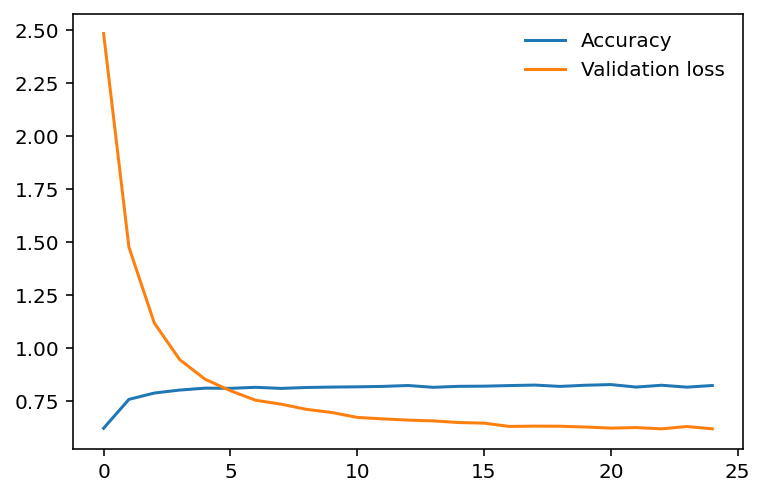

In [ ]:
plt.plot(val_acc, label='Accuracy')
plt.plot(val_loss, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [5]:
model = torch.load('/content/drive/My Drive/DogBreeding.pth')

In [18]:
class DogsDataset(Dataset):
    def __init__(self, img_dir, dataframe, transform=None):
        self.labels_frame = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.labels_frame.id[idx]) + ".jpg"
        image = Image.open(img_name)
        label = self.labels_frame.target[idx]

        if self.transform:
            image = self.transform(image)

        return [image, label] 

In [21]:
if torch.cuda.is_available():
    use_gpu = True
    print("Using GPU")
else:
    use_gpu = False

submission_df = pd.read_csv(sample_path)
output_df = pd.DataFrame(index=submission_df.index, columns=submission_df.keys() )
output_df['id'] = submission_df['id']
submission_df['target'] =  [0] * len(submission_df)

tdata_transform = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])

#test_ds = CDataset(submission_df, test_dir, class_df, class_to_idx, transform=tdata_transform)
print(train_ds)

test_ds = DogsDataset(test_dir, submission_df, tdata_transform)

sub_loader = DataLoader(test_ds, batch_size=58)


def test_sumission(model):
    since = time.time()
    sub_outputs = []
    model.train(False)  # Set model to evaluate mode
    # Iterate over data.
    for data in notebook.tqdm(sub_loader):
        # get the inputs
        inputs, labels = data

        if use_gpu:
            inputs = Variable(inputs.cuda(),)
            labels = Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        sub_outputs.append(outputs.data.cpu().numpy())

    sub_outputs = np.concatenate(sub_outputs)
    for idx,row in enumerate(sub_outputs.astype(float)):
        sub_outputs[idx] = np.exp(row)/np.sum(np.exp(row))

    output_df.loc[:,1:] = sub_outputs
        
    print()
    time_elapsed = time.time() - since
    print('Run complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return output_df

Using GPU


In [22]:
odf = test_sumission(model)
odf.to_csv("/content/drive/My Drive/dogs_id.csv", index=False)



Run complete in 103m 5s
